## Hands-on Synthetic Data

While traditional de-identification techniques, both perturbative and non-perturbative, have been widely used for many years, recent research trends are shifting towards synthetic data generation. This approach is gaining popularity due to its perceived lower privacy risks and its ability to avoid common issues associated with other privacy-preserving techniques. Unlike traditional methods, synthetic data generation requires less specialised expertise in data privacy, and the risk of disclosure is considerably lower. In this section, you will learn:

- synthetic data generation
- data utility assessment
- re-identification risk assessment

In [78]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
from sdmetrics.single_column import StatisticSimilarity, RangeCoverage, CategoryCoverage
from sdmetrics.column_pairs import CorrelationSimilarity

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import recordlinkage

In [2]:
# Read data
data = pd.read_csv("students-performance.csv")

In [3]:
data.shape

(649, 33)

In [4]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,class
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,High
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,High
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,High
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,High
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,High


In [5]:
# Split the data into 80% for synthesis and 20% for testing (data utility evaluation)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
train_data.shape, test_data.shape

((519, 33), (130, 33))

## Synthetic data generation

For data synthetisation we will be using the [SDV - Synthetic Data Vault](https://docs.sdv.dev/sdv/) library, which offers a comprehensive suite of the most widely recognised methods for generating synthetic data.

In [7]:
# Automatically detect the metadata (required parameter)
metadata = Metadata.detect_from_dataframe(data=train_data)

In [ ]:
metadata.save_to_json(filepath='metadata_students.json')

In [11]:
# Step 1: Initialise the synthesiser
synthesiser = CTGANSynthesizer(
    metadata,
    enforce_rounding=False,
    epochs=100,
    embedding_dim=64,
    batch_size=50,
    verbose=True
)

**metadata**: Specifies the metadata for the dataset, including information about data types, columns, and relationships. This helps the synthesizer understand the structure of the data.

**enforce_rounding**: If set to True, numerical columns are rounded to their nearest integer. Setting it to False prevents automatic rounding, which can be useful for continuous variables.

**epochs**: The number of training epochs. More epochs allow the model to learn better patterns from the data but may increase training time.

**embedding_dim**: The size of the embedding layer. A higher dimension can capture more complex patterns, but it also increases the model’s complexity.

**batch_size**: The number of samples processed before the model updates its parameters. Smaller batch sizes can lead to more stable training but may take longer.

In [12]:
# Step 2: Train the synthesiser
synthesiser.fit(train_data)

Gen. (-0.81) | Discrim. (0.01): 100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


In [13]:
# Step 3: Generate synthetic data
synthetic_data = synthesiser.sample(num_rows=train_data.shape[0])

In [14]:
synthetic_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,class
0,MS,M,15,U,LE3,T,4,2,at_home,other,...,2,2,5,1,4,3,0,9,12,Low
1,GP,F,17,R,GT3,T,4,2,other,services,...,4,3,3,1,2,5,0,6,11,High
2,GP,F,16,U,LE3,T,2,2,other,other,...,5,3,4,1,1,2,0,5,9,High
3,MS,M,16,U,GT3,A,3,1,health,other,...,5,4,4,1,2,5,0,12,16,High
4,GP,F,16,U,GT3,T,2,4,at_home,other,...,4,3,4,1,2,5,1,13,9,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,MS,M,15,U,GT3,T,1,2,services,other,...,4,5,2,1,1,5,3,8,8,High
515,MS,M,16,U,LE3,T,4,4,at_home,teacher,...,5,3,4,1,3,5,9,15,4,High
516,MS,F,17,U,GT3,T,4,3,other,other,...,4,3,4,1,4,5,0,6,13,High
517,MS,F,16,R,LE3,T,1,1,at_home,other,...,4,4,4,1,1,5,0,7,7,High


## Data utility -- general metrics

We can compare syntehtic data agains the real data using general metrics and visualizations.   [SDMetrics](https://docs.sdv.dev/sdmetrics) provides a set of general metrics for tabular synthetic data.

**CorrelationSimilarity**:
This metric measures the correlation between a pair of numerical columns and computes the similarity between the real and synthetic data.

(best) 1.0: The pairwise correlations of the real and synthetic data are exactly the same.

In [15]:
# Get numerical columns from the DataFrame
num_columns = train_data.select_dtypes(include=['number']).columns

In [16]:
CorrelationSimilarity.compute(
    real_data=train_data[num_columns],
    synthetic_data=synthetic_data[num_columns],
    coefficient='Pearson'
)

0.9102524416940192

**StatisticSimilarity**:
This metric measures the similarity between a real column and a synthetic column by comparing a summary statistic. Supported summary statistics are: mean, median and standard deviation

(best) 1.0: The statistic for the real data is exactly the same at the synthetic data

In [76]:
StatisticSimilarity.compute(
    real_data=train_data['age'],
    synthetic_data=synthetic_data['age'],
    statistic='mean'
)

0.9688962290118356

**RangeCoverage**:
This metric measures whether a synthetic column covers the full range of values that are present in a real column.

(best) 1.0: The synthetic column covers the range of values present in the real column.

In [77]:
RangeCoverage.compute(
    real_data=train_data['age'],
    synthetic_data=synthetic_data['age'],
)

0.7142857142857143

Text(0, 0.5, 'Age')

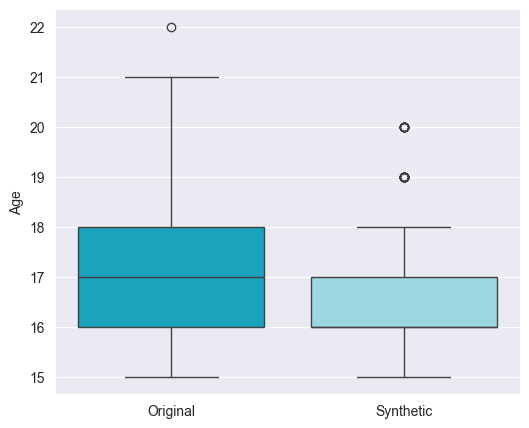

In [ ]:
# Plot the distribution of "Age" attribute
age = pd.DataFrame({
    'Age': pd.concat([train_data['age'], synthetic_data['age']], ignore_index=True),  # Combine both datasets into a single column
    'Dataset': ['Original'] * len(train_data) + ['Synthetic'] * len(synthetic_data)  # Labels for the datasets
})

sns.set_style('darkgrid')
plt.figure(figsize=(6, 5))

sns.boxplot(x='Dataset', y='Age', hue='Dataset',data=age,palette=['#00b4d8', '#90e0ef'])

plt.xlabel('')
plt.ylabel('Age')

**CategoryCoverage**:
This metric measures whether a synthetic column covers all the possible categories that are present in a real column.

(best) 1.0: The synthetic column contains all the unique categories present in the real column.

In [79]:
CategoryCoverage.compute(
    real_data=train_data['Mjob'],
    synthetic_data=synthetic_data['Mjob']
)

1.0

Text(0, 0.5, 'Mjob')

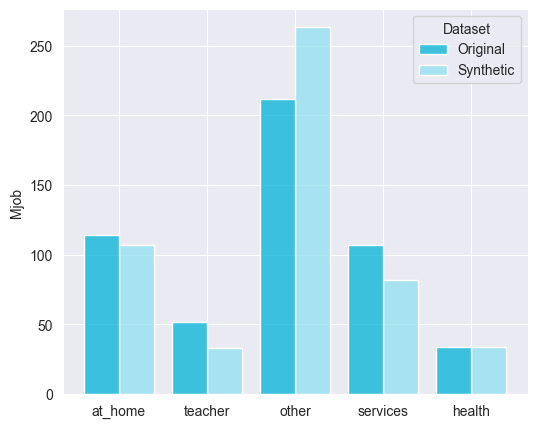

In [92]:
# Plot the distribution of "Mjob" attribute
mjob = pd.DataFrame({
    'mjob': pd.concat([train_data['Mjob'], synthetic_data['Mjob']], ignore_index=True),  # Combine both datasets into a single column
    'Dataset': ['Original'] * len(train_data) + ['Synthetic'] * len(synthetic_data)  # Labels for the datasets
})

sns.set_style('darkgrid')
plt.figure(figsize=(6, 5))

sns.histplot(data=mjob, x='mjob', hue='Dataset',multiple="dodge",
             shrink=.8,palette=['#00b4d8', '#90e0ef'])

plt.xlabel('')
plt.ylabel('Mjob')

## Data utility -- predictive performance

In [93]:
def modeling(train_data, test_data):
    # One-hot encode the train and test datasets
    encoded_train_data = pd.get_dummies(train_data, drop_first=True).astype(int)
    encoded_test_data = pd.get_dummies(test_data, drop_first=True).astype(int)

    # Split features (X) and target (y)
    X_train, y_train = encoded_train_data.iloc[:, :-1], encoded_train_data.iloc[:, -1]
    X_test, y_test = encoded_test_data.iloc[:, :-1], encoded_test_data.iloc[:, -1]

    # Initialise the Logistic Regression classifier
    randomforest = RandomForestClassifier()

    # Define the hyperparameter grid
    param_grid = {
        'n_estimators': [100, 250, 500],
        'max_depth': [4, 6, 8, 10]
    }

    # Perform Grid Search with 3-fold cross-validation
    grid_search = GridSearchCV(
        estimator=randomforest,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Make predictions on the test data using the best model
    y_pred = grid_search.best_estimator_.predict(X_test)

    return y_test, y_pred

#### Predictions for original data

In [94]:
# Train the model and get predictions for original
y_test, initial_preds = modeling(train_data, test_data)

# Calculate accuracy
accuracy_original = accuracy_score(y_test, initial_preds)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


#### Predictions for synthetic data

In [95]:
# Train the model and get predictions for synthetic
y_test, synthetic_preds = modeling(synthetic_data, test_data)
accuracy_synth = accuracy_score(y_test, synthetic_preds)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


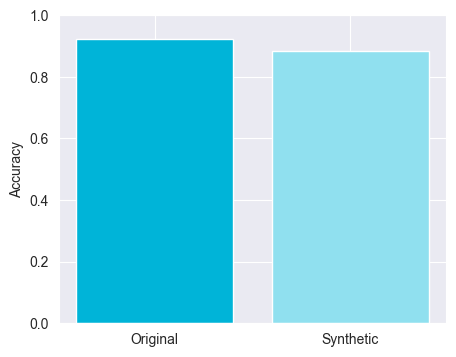

In [96]:
# Values for the bar plot
categories = ['Original', 'Synthetic']
values = [accuracy_original, accuracy_synth]

sns.set_style('darkgrid')
# Create the bar plot
plt.figure(figsize=(5, 4))
plt.bar(categories, values, color=['#00b4d8', '#90e0ef'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')

plt.show()

Percentage difference between the original and the transformed data.

$\frac{(𝑅_𝑎−𝑅_𝑏)}{𝑅_𝑏}∗100$, where $a$ is the transformed and $b$ is the baseline (original result)

In [97]:
(accuracy_synth-accuracy_original)/accuracy_original * 100

-4.166666666666676

## Data privacy -- linkability

## Data privacy -- record linkage

## Additional notes
- _Sampling methods_ are also used for synthesisation - they usually require less time to generate new data than deep learning-based models as often rely on nearest neighbor algorithms;
- Deep learning-based models typically better capture the distribution of data in larger data sets.
- Synthetic data also has an underlying _privacy risk_, namely, outliers are very likely to be identifiable since the synthetic data follows the original distribution. Furthermore, in the training process, an intruder can infer whether an individual is part of the training data (membership attacks);
- _Record linkage_ can be computationally intensive;
- Several scenarios must be considered for an effective risk evaluation, i.e. _different set of quasi-identifiers_.